# Análisis de constantes de filtrado


En esta notebook, haremos un análisis de las constantes para filtrar palabras y usuarios. En el trabajo original utilizamos 40 ocurrencias y 5 usuarios para filtrar, pero puede que no sea el mejor 



In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import re

df = pd.read_csv("../output/provinces_words.csv", index_col=0)
cant_palabras = [c for c in df.columns if re.match(r'.*ocurrencias$', c)]
cant_personas = [c for c in df.columns if re.match(r'.*usuarios$', c)]

df["cant_provincias"] = (df[cant_palabras] > 0).sum(axis=1)
df["cant_palabra"] = df[cant_palabras].sum(axis=1)
df["cant_usuarios"] = df[cant_personas].sum(axis=1)


In [2]:
print("Total de palabras: {}".format(df.shape[0]))

Total de palabras: 2330114


Text(0.5,1,'Cantidad acumulada de palabras con menos de X ocurrencias')

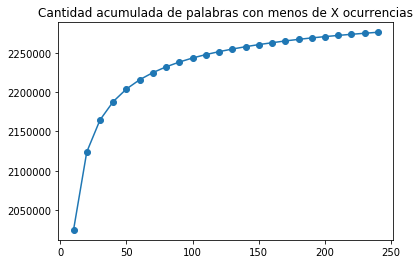

In [3]:
accum = {}
for i in range(1, 25):
    accum[10 * i] = len(df[df.cant_palabra < (10*i)])
pd.Series(accum).plot(marker="o")

plt.title("Cantidad acumulada de palabras con menos de X ocurrencias")

Text(0.5,1,'Cantidad acumulada de palabras con menos de X usuarios')

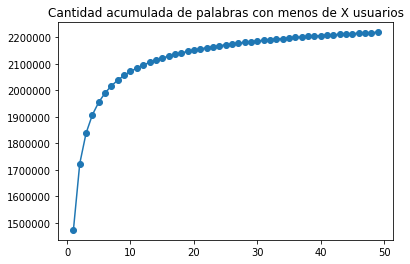

In [4]:
accum = {}
for i in range(1, 50, 1):
    accum[i] = len(df[df.cant_usuarios <= i])
pd.Series(accum).plot(marker="o")

plt.title("Cantidad acumulada de palabras con menos de X usuarios")

Pareciera tener algo de sentido elegir un filtro de entre 50 y 100 palabras, y alrededor de 10 personas.

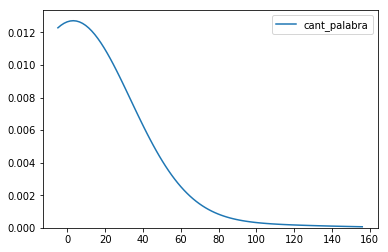

In [7]:
menores = df[df.cant_palabra <= 150]

sns.kdeplot(menores.cant_palabra, bw=2)

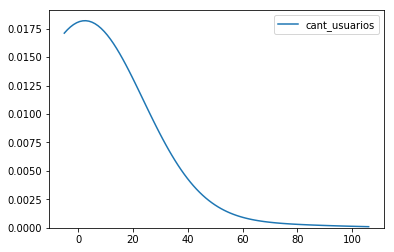

In [8]:

menos_de_100_usuarios = df[df.cant_usuarios <= 100]

sns.kdeplot(menos_de_100_usuarios.cant_usuarios, bw=2)

In [18]:
import numpy as np

chicas = df.sample(frac=0.01)

chicas["log_usuarios"] = np.log2(chicas.cant_usuarios)
chicas["log_palabra"] = np.log2(chicas.cant_palabra)

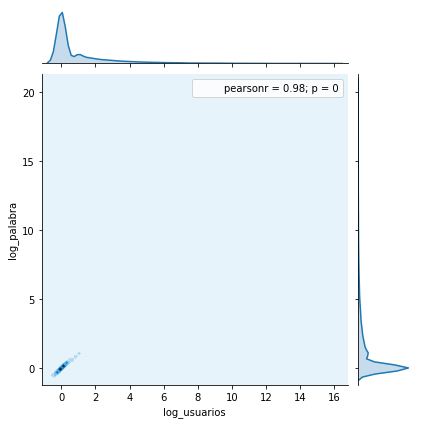

In [19]:
sns.jointplot(x="log_usuarios", y="log_palabra", data=chicas, kind="kde");


In [13]:
df[(df.cant_palabra > 10) & (df.cant_palabra < 20)].sample(20)["cant_palabra"]

palabra
khroos                                  11
rink                                    11
visistas                                11
rollie                                  11
agarranse                               13
besazooo                                17
chivih                                  11
nùmeros                                 19
pásatelo                                12
recrudecen                              17
cobijar                                 12
frrriiio                                16
depending                               15
jajajajajajjajajajajajajajajajajajaj    14
próxi                                   14
piernitass                              12
llooro                                  11
gabina                                  17
curadera                                12
cauâ                                    11
Name: cant_palabra, dtype: int64

## Cantidad de palabras OOV según cada filtro

Veamos qué ocurre con la cantidad de palabras OOV según cada uno de los filtros. ¿Se estanca en algún momento?


In [30]:
import hunspell
sc = hunspell.HunSpell("/usr/share/hunspell/es_AR.dic", "/usr/share/hunspell/es_AR.aff")
vocabulary = set()
accum = {}
for i in range(1, 25):
    palabras = df[df.cant_palabra < (10 * i)].index 
    cantidad = len(palabras)
    buenas = 0
    
    for w in palabras:
        try:
            if w in vocabulary or sc.spell(w):
                vocabulary.add(w)
                buenas+=1
        except:
            print(w)
            print("Skipping")
            
    accum[10 * i] = cantidad - buenas


nan
Skipping
nan
Skipping
nan
Skipping
nan
Skipping
nan
Skipping
nan
Skipping
nan
Skipping
nan
Skipping
nan
Skipping
nan
Skipping
nan
Skipping
nan
Skipping
nan
Skipping
nan
Skipping


Text(0.5,0,'Cantidad de ocurrencias')

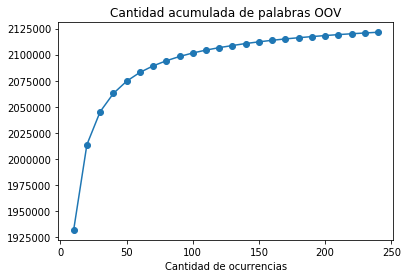

In [31]:
pd.Series(accum).plot(marker="o")

plt.title("Cantidad acumulada de palabras OOV")
plt.xlabel("Cantidad de ocurrencias")

In [34]:
import hunspell
sc = hunspell.HunSpell("/usr/share/hunspell/es_AR.dic", "/usr/share/hunspell/es_AR.aff")
vocabulary = set()
accum = {}
for i in range(1, 28):
    palabras = df[df.cant_usuarios < i].index 
    cantidad = len(palabras)
    buenas = 0
    
    for w in palabras:
        try:
            if w in vocabulary or sc.spell(w):
                vocabulary.add(w)
                buenas+=1
        except:
            print(w)
            print("Skipping")
            
    accum[i] = cantidad - buenas


Text(0.5,0,'Cantidad de usuarios')

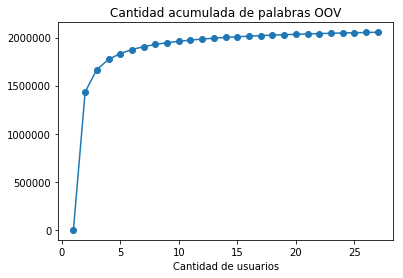

In [35]:
pd.Series(accum).plot(marker="o")

plt.title("Cantidad acumulada de palabras OOV")
plt.xlabel("Cantidad de usuarios")

# Distancia media de Levenshtein a una palabra con más ocurrencias?

Veamos en cada "slot" de a 10 ocurrencias qué pasa con la distancia media a una forma "mejor"

In [66]:
from nltk.metrics import edit_distance

palabra = "culiaw"
occ = df.loc[palabra].cant_palabra

palabras_otras = df[df.cant_palabra > occ].index


min_dist = min(edit_distance(palabra, otra_palabra) for otra_palabra in palabras_otras)

print("Mínimo distancia de edición para {} => {}".format(palabra, min_dist))
ejemplos = [w for w in palabras_otras if edit_distance(w, palabra) == min_dist]
print("ejemplos = {}".format(ejemplos))

Mínimo distancia de edición para culiaw => 1
ejemplos = ['culia', 'culiaa', 'culiao', 'culiar', 'culiau']


In [76]:
def more_common_form(df, palabra):
    occ = df.loc[palabra].cant_palabra
    
    candidatas = df[df.cant_palabra > occ].index
    
    
    min_dist = None 
    
    for w in candidatas:
        if min_dist is None:
            min_dist = edit_distance(w, palabra)
            ejemplos = [w]
        else:
            try:
                dist = edit_distance(w, palabra)

                if dist < min_dist:
                    min_dist = dist
                    ejemplos = [w]
                elif dist == min_dist:
                    ejemplos.append(w)
            except TypeError:
                pass
    return min_dist, ejemplos

In [79]:
more_common_form(df, "angaa")

(1, ['anaa', 'anaaa', 'andaa', 'anga', 'angaaa', 'angau'])

In [80]:
more_common_form(df, "kuliau")

(1, ['culiau', 'kulia', 'kuliao'])

In [81]:
more_common_form(df, "caarajo")

(1, ['caaarajo', 'carajo'])

In [98]:
%%time 
import random
import multiprocessing
from contextlib import closing

accum = {}

def dist(w):
    return more_common_form(df, w)[0]


for i in range(2, 10):
    lower = 20 * (i-1)
    upper = 20 * i
    
    print(lower, upper)
    
    palabras = df[(lower <= df.cant_palabra) & (df.cant_palabra < upper)].index 
    palabras = [p for p in palabras if isinstance(p, str)]
    
    samples = random.sample(palabras, 2000)
    
    with closing(multiprocessing.Pool(4, maxtasksperchild=1)) as pool:
        distances = pool.map(dist, samples)
    distances = np.array(distances)
    
    accum[upper] = distances.mean()

20 40
40 60
60 80
80 100
100 120
120 140
140 160
160 180
CPU times: user 11.7 s, sys: 8.66 s, total: 20.3 s
Wall time: 6h 39min 4s


Process ForkPoolWorker-184:
Process ForkPoolWorker-182:
Process ForkPoolWorker-181:
Process ForkPoolWorker-178:
Process ForkPoolWorker-176:
Process ForkPoolWorker-180:
Process ForkPoolWorker-183:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/jmperez/.pyenv/versions/3.6.4/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/jmperez/.pyenv/versions/3.6.4/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/jmperez/.pyenv/versions/3.6.4/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/home/jmperez/.pyenv/versions/3.6.4/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/jmperez/.pyenv/versions/3.6.4/lib/python3.6/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Tra

Text(0.5,1,'Promedio de Mínimas distancia a palabras con más ocurrencias')

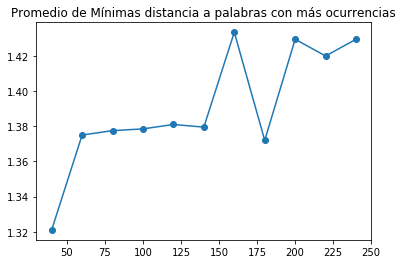

In [104]:
pd.Series(accum).plot(marker="o")

plt.title("Promedio de Mínimas distancia a palabras con más ocurrencias")


In [106]:
for i in range(13, 20):
    lower = 20 * (i-1)
    upper = 20 * i
    
    print(lower, upper)
    
    palabras = df[(lower <= df.cant_palabra) & (df.cant_palabra < upper)].index 
    palabras = [p for p in palabras if isinstance(p, str)]
    
    samples = random.sample(palabras, 100)
    
    with closing(multiprocessing.Pool(4, maxtasksperchild=1)) as pool:
        distances = pool.map(dist, samples)
    distances = np.array(distances)
    
    accum[upper] = distances.mean()

240 260
260 280
280 300
300 320
320 340
340 360
360 380


Text(0.5,1,'Promedio de Mínimas distancia a palabras con más ocurrencias')

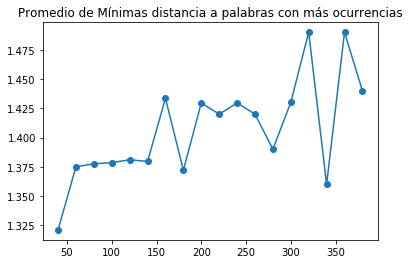

In [107]:
pd.Series(accum).plot(marker="o")

plt.title("Promedio de Mínimas distancia a palabras con más ocurrencias")

A ver, probemos con un poco menos y usando otras métricas (no sólo la media)

In [117]:
%%time 
distances = dict()

for i in range(1, 30):
    lower = 20 * (i-1)
    upper = 20 * i
    
    print(lower, upper)
    
    palabras = df[(lower <= df.cant_palabra) & (df.cant_palabra < upper)].index 
    palabras = [p for p in palabras if isinstance(p, str)]
    
    samples = random.sample(palabras, 120)
    
    with closing(multiprocessing.Pool(4, maxtasksperchild=1)) as pool:
        distances[upper] = np.array(pool.map(dist, samples))


0 20
20 40
40 60
60 80
80 100
100 120
120 140
140 160
160 180
180 200
200 220
220 240
240 260
260 280
280 300
300 320
320 340
340 360
360 380
380 400
400 420
420 440
440 460
460 480
480 500
500 520
520 540
540 560
560 580
CPU times: user 8.45 s, sys: 15.4 s, total: 23.9 s
Wall time: 1h 39min 4s


Text(0.5,1,'Promedio de máximas edit distance')

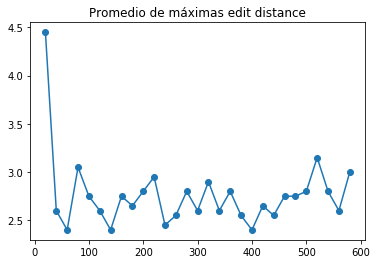

In [134]:
def max_promedio(v):
    return np.mean(sorted(v)[-20:])


pd.Series({k:max_promedio(v) for k, v in distances.items()}).plot(marker="o")

plt.title("Promedio de máximas edit distance")

Me parece que este análisis no echa mucha luz sobre el asunto...

En el final, yo creo que deberíamos normalizar el texto, y eventualmente ahí ver qué hacer con las otras palabras. Esto lo estamos haciendo con un remache del problema previo que tuvimos.

Algo que podríamos intentar argumentar: ¿cuánto "vocabulario" es relevante? 



# Frecuencia acumulada 

Veamos primero la proporción de palabras del total que tienen menos que $5i$ apariciones

Text(0.5,1,'Proporción acumulada de palabras con menos de X ocurrencias')

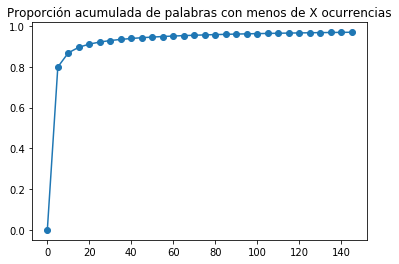

In [136]:
accum = { 0: 0 }

m = 5

for i in range(1, 30):
    accum[m * i] = len(df[df.cant_palabra < (m*i)]) / len(df)
pd.Series(accum).plot(marker="o")

plt.title("Proporción acumulada de palabras con menos de X ocurrencias")

Viendo esto, como mínimo hay que eliminar las que tienen menos de 20 ocurrencias.

Veamos qué pasa con los usuarios...

Text(0.5,1,'Proporción acumulada de palabras con menos de X usuarios')

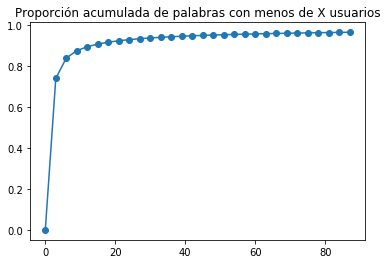

In [137]:
accum = { 0: 0 }

m = 3

for i in range(1, 30):
    accum[m * i] = len(df[df.cant_usuarios < (m*i)]) / len(df)
pd.Series(accum).plot(marker="o")

plt.title("Proporción acumulada de palabras con menos de X usuarios")

## Usando la masa de ocurrencias

Text(0.5,1,'Proporción acumulada de palabras con menos de X ocurrencias')

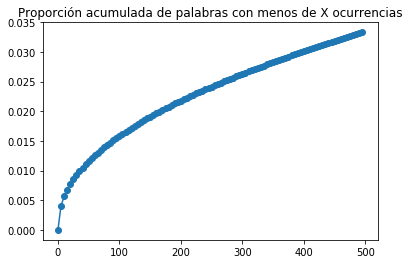

In [138]:


accum = { 0: 0 }

m = 5
total = df.cant_palabra.sum()

for i in range(1, 100):
    palabras = df[df.cant_palabra < (m*i)]
    accum[m * i] = palabras.cant_palabra.sum() / total
pd.Series(accum).plot(marker="o")

plt.title("Proporción acumulada de palabras con menos de X ocurrencias")

Este gráfico puede echar un poco más de luz. Acá el crecimiento de la masa de ocurrencias se estabiliza alrededor de 100.

Text(0.5,1,'Proporción acumulada de palabras con menos de X ocurrencias')

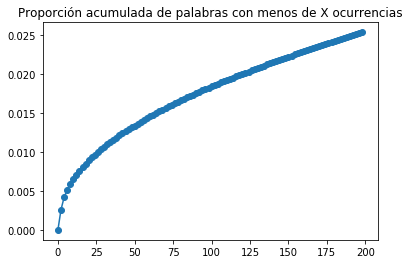

In [140]:


accum = { 0: 0 }

m = 2
total = df.cant_palabra.sum()

for i in range(1, 100):
    palabras = df[df.cant_usuarios < (m*i)]
    accum[m * i] = palabras.cant_palabra.sum() / total
pd.Series(accum).plot(marker="o")

plt.title("Proporción acumulada de palabras con menos de X ocurrencias")

Alrededor de 20 usuarios estabilizan las palabras...